In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executor import TrainingExecutor
from infilling.evaluation_executor import EvaluationExecutor
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
# Marshall Station but passing lat lon and year month to the hook 
# Hook provides different methods to download data for a station, + bounding box
# donwload hous in day, months, years
# cds.api retireive 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

# Download data for a station months
era5_hook.download_month(years, months, "ERA5hook_marshall")



Using URL: https://cds-beta.climate.copernicus.eu/api


2024-10-31 12:09:15,347 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-10-31 12:09:15,349 INFO Request ID is f25352f4-03ab-44fd-bf33-91b79e0eafdd
2024-10-31 12:09:15,824 INFO status has been updated to accepted
2024-10-31 12:09:19,849 INFO status has been updated to running
2024-10-31 12:09:23,339 INFO status has been updated to successful


In [ ]:
# Marshall Station but passing lat lon and year month to the hook 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

era5_hook.download_month(years, months, "ERA5hook_marshall")


In [4]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc

folder = "ERA5hook_marshall"
era5_target_file_path = f"{folder}/era5.nc"

# Conversion
# converts grib to nc 
# using cdo command -f nc4 copy result is 0.25x0.25grid 
# renames variables 
# merges files


Era5DataFromGribToNc(
    folder_path=folder,
    era5_target_file_path=era5_target_file_path
)




Found 2020_6.grib
Merging files...
Merged ERA5 file saved into ERA5hook_marshall/era5.nc


In [6]:
ds = xr.open_dataset("ERA5hook_marshall/era5.nc")
ds


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 720, lon: 9, lat: 9)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
  * lon      (lon) float64 72B 253.8 254.1 254.3 254.6 ... 255.3 255.6 255.8
  * lat      (lat) float64 72B 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2 38.95
Data variables:
    t2m      (time, lat, lon) float32 233kB ...
    tp       (time, lat, lon) float32 233kB ...
    u10      (time, lat, lon) float32 233kB ...
    v10      (time, lat, lon) float32 233kB ...
    sp       (time, lat, lon) float32 233kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Nov 01 16:03:46 2024: cdo mergetime /var/folders/lj/q1n...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

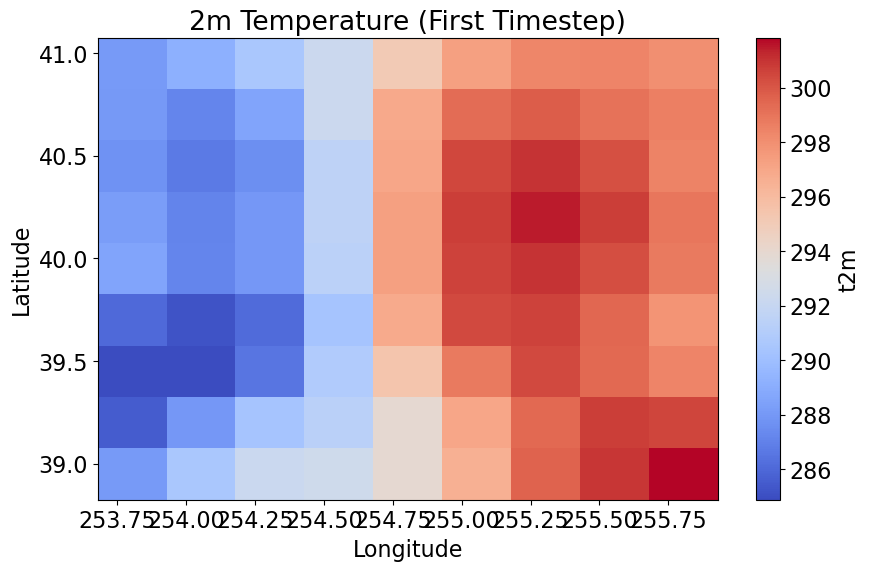

In [8]:
# Select the first timestep of 't2m' and plot it
t2m_first_timestep = ds['t2m'].isel(time=-3)

# Plotting
plt.figure(figsize=(10, 6))
t2m_first_timestep.plot(cmap='coolwarm')
plt.title("2m Temperature (First Timestep)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## GPT explanation

Extracting Vienna_station_name...


100%|██████████| 1857/1857 [01:27<00:00, 21.22it/s]


displaying lon: 16.3609
as 16.361


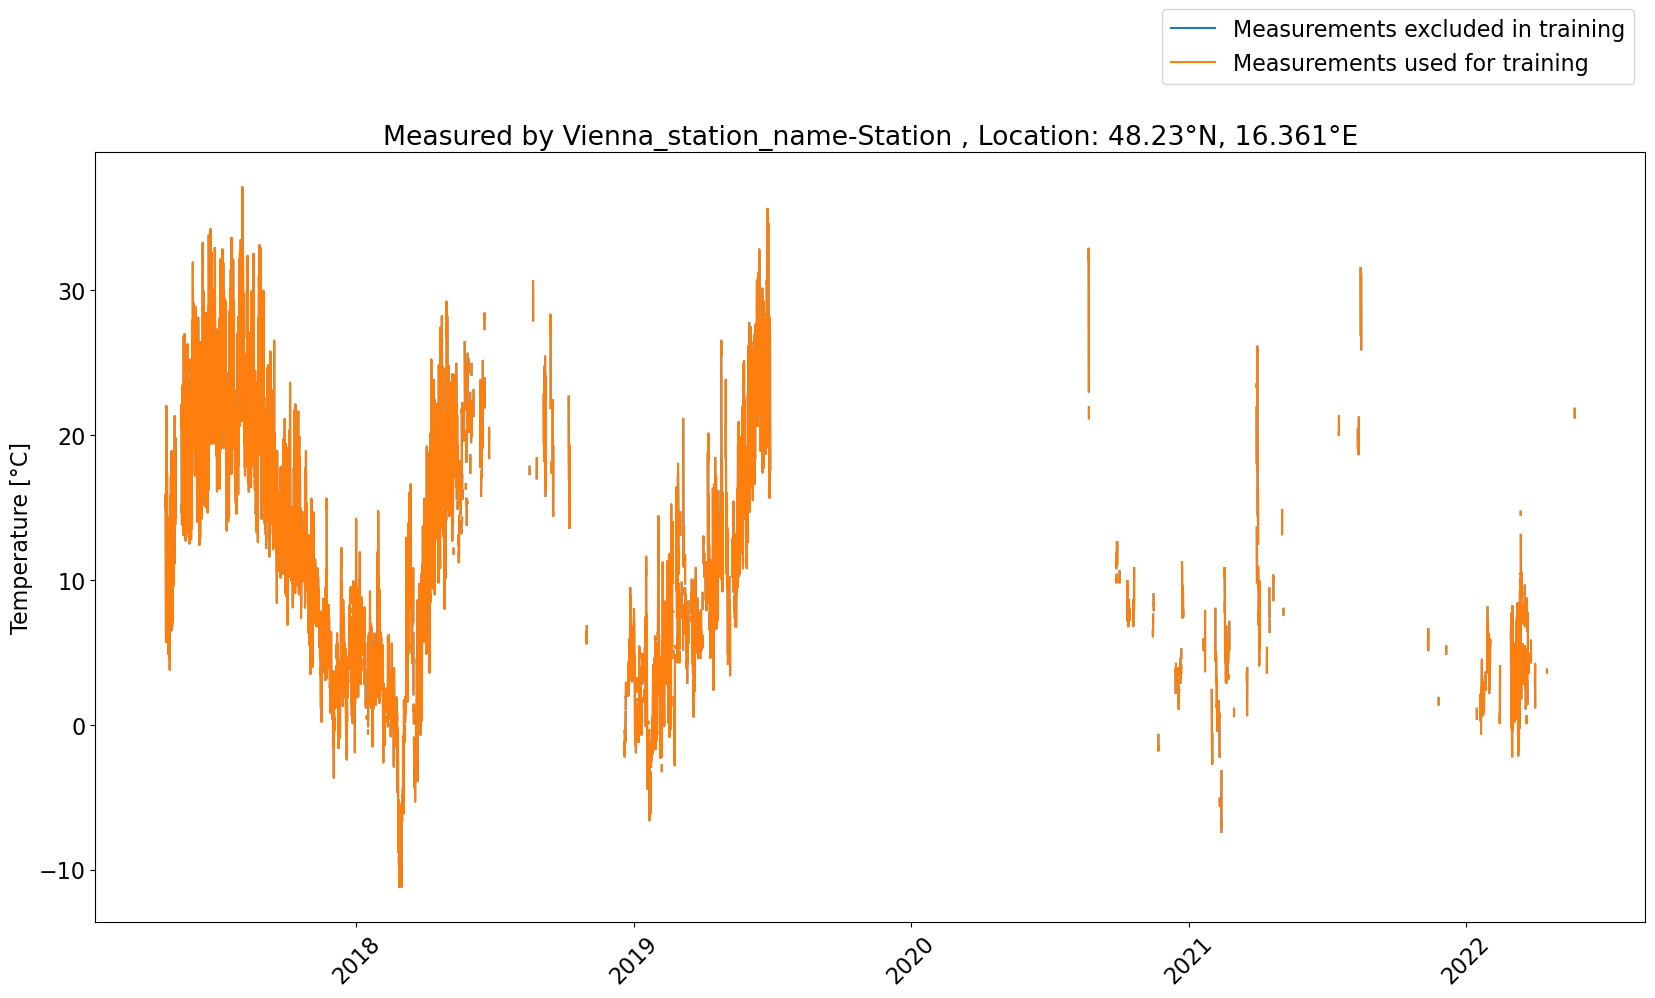

In [3]:
# Initialize the station data
# Processes all dat files, extracts metadata cleans data uses DattoNxConverter
vienna_station = StationData(
    name='Vienna_station_name',
    folder_path='measurements/Vienna',
    #mask_years=[2020]  # Optionally mask out certain years
)

In [12]:
# Initialize the ERA5 download hook
era5_hook = Era5DownloadHook(lat=vienna_station.metadata['latitude'], lon=vienna_station.metadata['longitude'])

Using URL: https://cds-beta.climate.copernicus.eu/api


In [13]:
grib_dir_path = 'measurements/Testing'

# Download ERA5 data for the station
era5_downloader = DownloadEra5ForStation(vienna_station, grib_dir_path, era5_hook)
era5_downloader.execute()

Downloading... 2017


2024-11-01 16:30:05,304 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-01 16:30:05,304 INFO Request ID is c37bbc55-2f4e-4bb3-a87b-6d28b473481b
2024-11-01 16:30:05,373 INFO status has been updated to accepted
2024-11-01 16:30:09,346 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
2024-11-01 21:18:05,920 INFO status has been updated to failed


HTTPError: 400 Client Error: Bad Request for url: https://cds.climate.copernicus.eu/api/retrieve/v1/jobs/c37bbc55-2f4e-4bb3-a87b-6d28b473481b/results
The job has failed.
The job failed with: TypeError

In [4]:
# bypassing the download of the data

from era5.era5_for_station import Era5ForStationCropper
from station.station import StationData

# Paths for ERA5 data
merged_era5_nc_path = 'ERA5_DRKZ/vienna_t2m_2017-2024_data.nc'       # Existing NetCDF ERA5 data
cropped_era5_nc_path = 'ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc'    # Output path for cropped ERA5 data

# Initialize the cropper
era5_cropper = Era5ForStationCropper(
    station=vienna_station,
    era5_path=merged_era5_nc_path,
    era5_target_path=cropped_era5_nc_path
)

# Execute cropping
era5_cropper.execute()


Latitudes are sorted in ascending order.
Lat:  48.2303
Lon:  16.3609
search: 16.3609  in asc_lon_list: [14.   14.25 14.5  14.75 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75
 17.   17.25 17.5  17.75 18.  ]
nearest_lon_idx: 9
nearest_lat_idx: 9
nearest_lat: 48.25
nearest_lon: 16.25
nearest lon is smaller
nearest lat is bigger
crop_lon_idx_min: 6
crop_lon_idx_max: 13
crop_lat_idx_min: 5
crop_lat_idx_max: 12
Lon values after cropping: [15.5  15.75 16.   16.25 16.5  16.75 17.   17.25]
Lat values after cropping: [47.25 47.5  47.75 48.   48.25 48.5  48.75 49.  ]
Era5 for station cropped and exported to: ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc


In [6]:
cropped_data = xr.open_dataset('ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc')
print(cropped_data)

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    var167   (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Oct 30 22:21:53 2024: cdo mergetime /home/k/k202207/ERA...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...


In [8]:
vienna_station.df

,uv_light,vis_light,tas,ir_light
datetime,,,,
2017-04-24 14:00:00,35.0,323.0,288.05,658.0
2017-04-24 15:00:00,32.0,316.0,288.75,607.0
2017-04-24 16:00:00,23.0,299.5,289.05,511.5
2017-04-24 17:00:00,10.0,276.0,288.55,364.5
2017-04-24 18:00:00,2.0,261.0,286.80,253.0
...,...,...,...,...
2022-04-18 02:00:00,NaN,261.0,276.75,252.5
2022-05-24 12:00:00,167.0,569.0,295.05,3174.0
2022-05-24 14:00:00,123.0,486.0,294.95,2275.0


In [11]:
# Load the cropped ERA5 data
era5_data = xr.open_dataset('ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc')

# Extract the 2m temperature variable (assuming it's named 't2m')
era5_t2m = era5_data['var167']
era5_t2m_celsius = era5_t2m 

# Extract station temperature data (assuming 'tas' is in Kelvin)
station_tas_celsius = vienna_station.df['tas'] 

# Align time indices if necessary
era5_t2m_celsius, station_tas_celsius = xr.align(era5_t2m_celsius, station_tas_celsius, join='inner')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(era5_t2m_celsius.time, era5_t2m_celsius, label='ERA5 2m Temperature')
plt.plot(station_tas_celsius.index, station_tas_celsius, label='Station Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Comparison: ERA5 vs. Station')
plt.legend()
plt.show()


AttributeError: 'Series' object has no attribute 'xindexes'

In [12]:
# Initialize StationData


# Find missing hours
missing_hours = vienna_station.find_gaps()
print(f"Number of missing hours: {len(missing_hours)}")
print("Missing Hours:", missing_hours)


Number of missing hours: 32077
Missing Hours: [Timestamp('2017-04-24 07:00:00'), Timestamp('2017-04-24 08:00:00'), Timestamp('2017-04-24 09:00:00'), Timestamp('2017-04-24 10:00:00'), Timestamp('2017-04-24 11:00:00'), Timestamp('2017-04-24 12:00:00'), Timestamp('2017-04-24 13:00:00'), Timestamp('2017-04-27 06:00:00'), Timestamp('2017-04-27 17:00:00'), Timestamp('2017-04-27 23:00:00'), Timestamp('2017-04-28 02:00:00'), Timestamp('2017-04-28 03:00:00'), Timestamp('2017-04-28 06:00:00'), Timestamp('2017-04-28 14:00:00'), Timestamp('2017-04-29 02:00:00'), Timestamp('2017-04-30 22:00:00'), Timestamp('2017-05-01 01:00:00'), Timestamp('2017-05-01 02:00:00'), Timestamp('2017-05-01 03:00:00'), Timestamp('2017-05-01 04:00:00'), Timestamp('2017-05-03 20:00:00'), Timestamp('2017-05-05 20:00:00'), Timestamp('2017-05-07 01:00:00'), Timestamp('2017-05-07 16:00:00'), Timestamp('2017-05-07 17:00:00'), Timestamp('2017-05-07 18:00:00'), Timestamp('2017-05-07 19:00:00'), Timestamp('2017-05-07 20:00:00'), T

In [13]:
# Get all available months grouped by year
years_by_months = vienna_station.get_all_months_in_df()
print(years_by_months)
# Example Output: {2019: [1, 2, 3], 2021: [5, 6, 7, 8]}


{2017: [4, 5, 6, 7, 8, 9, 10, 11, 12], 2018: [1, 2, 3, 4, 5, 6, 8, 9, 10, 12], 2019: [1, 2, 3, 4, 5, 6], 2020: [8, 9, 10, 11, 12], 2021: [1, 2, 3, 4, 5, 7, 8, 11, 12], 2022: [1, 2, 3, 4, 5]}


In [14]:
# Export station data to NetCDF
target_dir = 'measurements/Testing'
nc_file_path = vienna_station.export_as_nc(target_directory=target_dir)
print(f"Station data exported to: {nc_file_path}")


(12477,) hourly temperature values in dataframe
Saving to measurements/Testing/vienna_station_name.nc
Station data exported to: measurements/Testing/vienna_station_name.nc


In [15]:
# loading exported nc file again as station data
# Path to your exported station NetCDF file
station_nc_path = 'measurements/Testing/vienna_station_name.nc'

# Load the NetCDF dataset
station_ds = xr.open_dataset(station_nc_path)

# Inspect the dataset
print(station_ds)

<xarray.Dataset> Size: 200kB
Dimensions:  (time: 12477, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lat      (lat) float64 8B 48.23
  * lon      (lon) float64 8B 16.36
Data variables:
    tas      (time, lat, lon) float64 100kB ...


In [ ]:
from station.station import StationData
from era5.era5_download_hook import Era5DownloadHook
from era5.era5_downloader import DownloadEra5ForStation
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc
from era5.era5_downloader import Era5ForStationCropper

# Step 1: Initialize StationData
station = StationData(
    name='MyStation',
    folder_path='/path/to/station_data',
    mask_years=[]
)

# Step 2: Initialize ERA5 Download Hook
era5_hook = Era5DownloadHook(
    lat=station.metadata['latitude'],
    lon=station.metadata['longitude']
)

# Step 3: Download ERA5 Data
grib_dir_path = '/path/to/grib/files'
era5_downloader = DownloadEra5ForStation(
    station=station,
    grib_dir_path=grib_dir_path,
    hook=era5_hook
)

# Step 4: Convert and Merge GRIB Files to NetCDF
era5_nc_path = '/path/to/era5.nc'
era5_converter = Era5DataFromGribToNc(
    folder_path=grib_dir_path,
    era5_target_file_path=era5_nc_path
)

# Step 5: Crop ERA5 Data to Match Station Data
era5_cropped_path = '/path/to/era5_cropped.nc'
era5_cropper = Era5ForStationCropper(
    station=station,
    era5_path=era5_nc_path,
    era5_target_path=era5_cropped_path
)
era5_cropper.execute()

# Now you can proceed with your analysis using 'station' and 'era5_cropped_path'


In [ ]:
from station.station import StationData
from era5.era5_download_hook import Era5DownloadHook
from era5.era5_downloader import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc
from era5.era5_downloader import Era5ForStationCropper

# Step 1: Initialize StationData
station = StationData(
    name='MyStation',
    folder_path='/path/to/station_data',
    mask_years=[]  # Specify years to exclude if any
)

# Step 2: Find Missing Hours
missing_hours = station.find_gaps()
print(f"Missing hours: {missing_hours}")

# Step 3: Get Available Months
years_by_month = station.get_all_months_in_df()
print(f"Available months by year: {years_by_month}")

# Step 4: Export Station Data to NetCDF
station_nc_path = station.export_as_nc(target_directory='/path/to/save/nc_files')
print(f"Station data exported to: {station_nc_path}")

# Step 5: Initialize ERA5 Download Hook
era5_hook = Era5DownloadHook(
    lat=station.metadata['latitude'],
    lon=station.metadata['longitude']
)

# Step 6: Download ERA5 Data
grib_dir_path = '/path/to/grib/files'

# Option A: Download All ERA5 Data
era5_downloader = DownloadEra5ForStation(
    station=station,
    grib_dir_path=grib_dir_path,
    hook=era5_hook
)

# Option B: Download Only Missing ERA5 Data (Uncomment if needed)
# era5_gap_downloader = DownloadEra5ForStationGaps(
#     station=station,
#     grib_dir_path=grib_dir_path,
#     hook=era5_hook
# )

# Step 7: Convert and Merge GRIB Files to NetCDF
era5_nc_path = '/path/to/era5.nc'
era5_converter = Era5DataFromGribToNc(
    folder_path=grib_dir_path,
    era5_target_file_path=era5_nc_path
)

# Step 8: Crop ERA5 Data to Match Station Data
era5_cropped_path = '/path/to/era5_cropped.nc'
era5_cropper = Era5ForStationCropper(
    station=station,
    era5_path=era5_nc_path,
    era5_target_path=era5_cropped_path
)
era5_cropper.execute()

# Now, both station data (in NetCDF format) and ERA5 data (cropped) are ready for analysis.


In [ ]:
from station.station import StationData
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Initialize StationData
station = StationData(
    name='ViennaStation',
    folder_path='/path/to/vienna_station_data',
    mask_years=[2020]  # Example: Mask out the year 2020
)

# Step 2: Identify Missing Data Gaps
missing_hours = station.find_gaps()
print(f"Number of missing hours: {len(missing_hours)}")

# Load ERA5 data
cropped_era5_nc_path = '/path/to/cropped_era5.nc'
era5_data = xr.open_dataset(cropped_era5_nc_path)

# Step 3: Extract ERA5 Data for Missing Hours
if missing_hours:
    missing_times = pd.to_datetime(missing_hours)
    # Ensure ERA5 data covers the missing times
    valid_missing_times = missing_times[(missing_times >= era5_data.time.min().values) &
                                       (missing_times <= era5_data.time.max().values)]
    if not valid_missing_times.empty:
        missing_era5_data = era5_data.sel(time=valid_missing_times, method='nearest')
        print("Extracted ERA5 data for missing hours:")
        print(missing_era5_data)
        
        # Convert ERA5 temperature to Celsius
        era5_t2m_celsius = missing_era5_data['t2m'] - 273.15
        
        # Align with station DataFrame
        station_df = station.df.copy()
        station_df, era5_t2m_celsius = station_df.align(era5_t2m_celsius, join='left')
        
        # Fill NaN values in station data with ERA5 data
        station_df['tas_filled'] = station_df['tas'].fillna(era5_t2m_celsius)
        
        # Update the station DataFrame
        station.df = station_df
        
        # Verify filling
        print(station.df[['tas', 'tas_filled']].head())
    else:
        print("No valid missing times within the ERA5 data range.")
else:
    print("No missing hours found in station data.")

# Step 4: Retrieve Available Months
years_by_months = station.get_all_months_in_df()
print("Available Months by Year:", years_by_months)

# Step 5: Export Filled Station Data to NetCDF
target_dir = '/path/to/exported_nc_files'
filled_nc_file_path = station.export_as_nc(target_directory=target_dir)
print(f"Filled station data exported to: {filled_nc_file_path}")

# Step 6: Visualize Original vs. Filled Data
plt.figure(figsize=(15, 5))
plt.plot(station.df.index, station.df['tas'], label='Original Station Data')
plt.plot(station.df.index, station.df['tas_filled'], label='Filled Station Data', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Station Temperature Data: Original vs. Filled')
plt.legend()
plt.show()
